In [1]:
import sys, os
import scipy.io, numpy
import netCDF4

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

Ultimately want to plot size distribution & number fraction of particle types as a function of time, distinguishing particles between FRESH/AGED/VERY AGED based on various thresholds.

Thresholds:

Sea Salt -

    Aged        25% chloride depleted

Biomass Burning -

    Aged        > 20% secondary

    Very aged   > 80% secondary

Soot - 

    Aged        (Not yet established)

    Very aged   (Not yet established)

Step 1: 
    
    Bin particles by size

Step 2: 
    
    Apply masks to distinguish between particles containing primary species(start by using oc as primary species)

Step 3: 
    
    Calculate aged and fresh oc number fractions for each size bin, this will give aged and fresh oc number fractions, the sum of these two values should not equal 1, there will be a number fraction of particles that do not contain oc in each size bin

Step 4: 
    
    Plot

TO DO: 
    
    Put better labels and axes on plots, make a markdown cell that explains what is seen in the plots


In [2]:
directory = '/data/keeling/a/yicenl2/d/project_n2o5/scenario_libs/wsd/0_hydr_noo/scenarios/scenario_0000'

# Initialize lists and arrays
aero_particle_mass = [] 
aero_num_conc = []
t_index = []
aero_density = np.zeros(20)

for subdir, dirs, files in os.walk(directory):
    for file in files:
        filename = subdir + os.sep + file
        if ("out/urban_plume_0001_000000" in filename):
            # Get time index
            t_index.append(int(filename[-5:-3]) - 1)
            t_index.sort()
            pos = t_index.index(int(filename[-5:-3]) - 1)
            ncf  = scipy.io.netcdf_file(filename, mmap=False)
            # Initialize arrays for each time index
            aero_particle_mass.insert(pos , (np.zeros((20, np.max(ncf.variables["aero_particle"].data)))) )
            aero_num_conc.insert(pos, (np.zeros(np.max(ncf.variables["aero_particle"].data))) )
            # Fill arrays in with data
            aero_particle_mass[pos][:, :] = ncf.variables["aero_particle_mass"].data
            aero_num_conc[pos][:] = ncf.variables["aero_num_conc"].data
            aero_density[:] = ncf.variables["aero_density"].data

In [3]:
# Initialize lists of useful values
total_aero_particle_mass_conc = []
total_aero_particle_mass = []
total_num_conc = []
aero_particle_volume = []
aero_particle_diam = []

# Fill in lists
for t in range(len(t_index)):
    total_aero_particle_mass_conc.append(np.sum(aero_particle_mass[t] * aero_num_conc[t], axis=0))
    total_aero_particle_mass.append(np.sum(aero_particle_mass[t], axis=0))
    total_num_conc.append(np.sum(aero_num_conc[t]))
    aero_particle_volume.append(np.sum((aero_particle_mass[t].T/aero_density).T, axis=0))
    aero_particle_diam.append((2 * ((aero_particle_volume[t] * 3/(4 * np.pi)) ** (1/3))) * 1e6) # change

# List of species names and primary/secondary species indices, initialize dictionary to contain mass fractions
species = ['so4','no3','cl','nh4','msa','aro1','aro2','alk1','ole1','api1','api2','lim1','lim2','co3','na','ca','oin','oc','bc','h2o']
primary_indices = [2, 4, 13, 14, 15, 16, 17, 18, 19]
secondary_indices = [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12]
soa_indices = [5, 6, 7, 8, 9, 10, 11, 12]
mass_fracs = {}

# Fill in dictionary:   20 dictionary items, each item a list of 25 arrays for each species, 
#                       each array the mass fraction of the species for the particles in that timestep
for i in range(len(species)):
    mass_fracs['mass_frac_' + str(species[i])] = []
    for t in range(len(t_index)):
        mass_fracs['mass_frac_' + str(species[i])].append( (aero_particle_mass[t][i, :] * aero_num_conc[t]) / total_aero_particle_mass_conc[t])

In [4]:
# Create list of mass fractions of primary species, length = primary species x timesteps x # of particles in timestep
primary_mass_frac_list = []

for i in primary_indices:
    primary_mass_frac_list.append(mass_fracs['mass_frac_' + str(species[i])])

# Create and fill in lists for the mass fraction of primary/secondary species in each particle, lengths = timesteps x # of particles in timestep
# These lists are to be used when establishing masks, as they will identify which particles have a 
# higher/lower secondary mass fraction than the defined threshold

mass_frac_primary = []
mass_frac_secondary = []

for t in range(len(t_index)):
    mass_frac_primary.append(np.sum(aero_particle_mass[t][primary_indices] * aero_num_conc[t], axis=0)/total_aero_particle_mass_conc[t])
    mass_frac_secondary.append(1 - mass_frac_primary[t])

* Make N bins

* Apply masks to only account for OC containing particles for now

* Create *empty* fresh and aged arrays

* Check if particle's diameter is within bin range, then add particle to corresponding fresh or aged array within that bin

* Repeat for each bin

* Determine number fractions of each array in each bin. 

* Fresh and aged number fractions should not add up to 1 at this stage because not all particles within each size bin will contain OC 

In [5]:
# Initialize thresholds and lists of masks for each timestep
# Threshold list values are subject to change
threshold_list = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
fresh_mask = []
aged_mask = []
non_primary_mask = []

# Fill in mask lists, lengths timesteps x primary species x # of particles in timestep
for t in range(len(t_index)):
  fm=[]
  am = []
  npm = []
  for i in range(len(primary_mass_frac_list)):
    fm.append((primary_mass_frac_list[i][t][:] > 0) & (mass_frac_secondary[t] < threshold_list[i]))
    am.append((primary_mass_frac_list[i][t][:] > 0) & (mass_frac_secondary[t] > threshold_list[i]))
    npm.append((primary_mass_frac_list[i][t][:] == 0))
  fresh_mask.append(fm)
  aged_mask.append(am)
  non_primary_mask.append(npm)

In [6]:
# Initialize lists for particle diameters masked by fresh, aged, and non primary
fresh_diam = []
aged_diam = []
non_primary_diam = []

# Fill in diameter lists, lengths timesteps x primary species x # of particles in timestep
for t in range(len(t_index)):
  fd = []
  ad = []
  npd = []
  for i in range(len(primary_mass_frac_list)):
    fd.append(aero_particle_diam[t][fresh_mask[t][i]])
    ad.append(aero_particle_diam[t][aged_mask[t][i]])
    npd.append(aero_particle_diam[t][non_primary_mask[t][i]])
  fresh_diam.append(fd)
  aged_diam.append(ad)
  non_primary_diam.append(npd) 

In [7]:
# Initialize lists for number concentrations masked by fresh, aged, and non primary
fresh_num_conc = []
aged_num_conc = []
non_primary_num_conc = []

# Fill in number concentration lists, lengths timesteps x primary species x # of particles in timestep
for t in range(len(t_index)):
  fnc = []
  anc = []
  npnc = []
  for i in range(len(primary_mass_frac_list)):
    fnc.append(aero_num_conc[t][fresh_mask[t][i]])
    anc.append(aero_num_conc[t][aged_mask[t][i]])
    npnc.append(aero_num_conc[t][non_primary_mask[t][i]])
  fresh_num_conc.append(fnc)
  aged_num_conc.append(anc)
  non_primary_num_conc.append(npnc)
  
# Indexing for all final lists is as follows:
# list[timestep][primary species]
# For example, to retrieve the diameter of fresh particles containing OC at the 4th timestep, call the following:
# fresh_diam[3][6] 

**Indexing for all final lists is as follows:**

```
list[timestep][primary species]
```

**For example, to retrieve the diameter of fresh particles containing OC at the 4th timestep, call the following:**

```
fresh_diam[3][6]
```

In [10]:
# make edges of size bins
diam_bins = np.logspace(-8, -3, 51) * 1e6

In [11]:
# Bin particles
# Initialize lists for binned particles
fresh_binned = []
aged_binned = []
non_primary_binned = []

# Fill in lists, lists are 25x9x2x50:
# 25 timesteps, 9 species, a tuple of 2 arrays each of shape 50, the first being num conc in the size bins, the second being size bin edges
for t in range(len(t_index)):
    fb = []
    ab = []
    npb = []
    for i in range(len(primary_mass_frac_list)):
        fb.append(np.histogram(fresh_diam[t][i], diam_bins, weights= fresh_num_conc[t][i]))
        ab.append(np.histogram(aged_diam[t][i], diam_bins, weights= aged_num_conc[t][i]))
        npb.append(np.histogram(non_primary_diam[t][i], diam_bins, weights= non_primary_num_conc[t][i]))
    fresh_binned.append(fb)
    aged_binned.append(ab)
    non_primary_binned.append(npb)

In [12]:
# want total binned num conc to be 25x9x50, final elements being arrays of the sum of fresh binned, aged binned, and non primary binnned 
total_binned_num_conc = []

for t in range(len(t_index)):
    tbnc = []
    for i in range(len(primary_mass_frac_list)):
        tbnc.append(fresh_binned[t][i][0] + aged_binned[t][i][0] + non_primary_binned[t][i][0])
    total_binned_num_conc.append(tbnc)

In [13]:
# Calculating number fractions of fresh, aged, and non primary containing particles
fresh_frac = []
aged_frac = []
non_primary_frac = []

for t in range(len(t_index)):
    ff = []
    af = []
    npf = []
    for i in range(len(primary_mass_frac_list)):
        ff.append(np.nan_to_num(fresh_binned[t][i][0] / total_binned_num_conc[t][i]))
        af.append(np.nan_to_num(aged_binned[t][i][0] / total_binned_num_conc[t][i]))
        npf.append(np.nan_to_num(non_primary_binned[t][i][0] / total_binned_num_conc[t][i]))
    fresh_frac.append(ff)
    aged_frac.append(af)
    non_primary_frac.append(npf)

/tmp/ipykernel_150821/2219328032.py:11: RuntimeWarning: invalid value encountered in divide
  ff.append(np.nan_to_num(fresh_binned[t][i][0] / total_binned_num_conc[t][i]))
/tmp/ipykernel_150821/2219328032.py:12: RuntimeWarning: invalid value encountered in divide
  af.append(np.nan_to_num(aged_binned[t][i][0] / total_binned_num_conc[t][i]))
/tmp/ipykernel_150821/2219328032.py:13: RuntimeWarning: invalid value encountered in divide
  npf.append(np.nan_to_num(non_primary_binned[t][i][0] / total_binned_num_conc[t][i]))


In [14]:
# calculate geometric mean for locations of bars in each bin in plots
diam_bins_geomean = np.sqrt(fresh_binned[0][0][1][1:] * fresh_binned[0][0][1][:-1])

# calculate width of bars/bins for plots
diam_bins_width = fresh_binned[0][0][1][1:] - fresh_binned[0][0][1][:-1]

num_conc_binned = []

for t in range(len(t_index)):
    num_conc_binned.append(np.histogram(aero_particle_diam[t], diam_bins, weights= aero_num_conc[t]))

# check to see if num_conc_binned can just be replaced by total_binned_num_conc
# I don't think it will be replaceable completely because num_conc_binned seems to account for number concentrations of all particles,
# whereas total_binned_num_conc may just account for the primary species ???

In [15]:
# Exclude co3 and ca in mass frac arrays and plots, as they are found to have zero mass in this simulation
excluded_indices = [13, 15]

mass_binned = []
for t in range(len(t_index)):
    mb = []
    for i in range(int(len(species)-1)):
        if i not in soa_indices + excluded_indices:
            mb.append((np.histogram(aero_particle_diam[t], diam_bins, weights= aero_particle_mass[t][i]))[0])
            
    # binned sum of SOA species masses
    soa_mb = np.histogram(aero_particle_diam[t], diam_bins, weights= np.sum(aero_particle_mass[t][soa_indices[:]], axis=0))[0]
    mb.append(soa_mb)
    mass_binned.append(mb)
    
total_mass_binned = []
for t in range(len(t_index)):
    total_mass_binned.append(np.sum(mass_binned[t], axis=0))

mass_frac_binned = []
for t in range(len(t_index)):
    mass_frac_binned.append(np.nan_to_num(mass_binned[t] / total_mass_binned[t]))

indices_plt_order = [0, 1, 3, 7, 9, 8, 6, 5, 2, 4]
mass_frac_binned_plt = []
for t in range(len(t_index)):
    mfbp = np.zeros((10, 50))
    for i in range(len(indices_plt_order)):
        mfbp[i] = mass_frac_binned[t][indices_plt_order[i]]
    mass_frac_binned_plt.append(mfbp)

/tmp/ipykernel_150821/3797302676.py:22: RuntimeWarning: invalid value encountered in divide
  mass_frac_binned.append(np.nan_to_num(mass_binned[t] / total_mass_binned[t]))


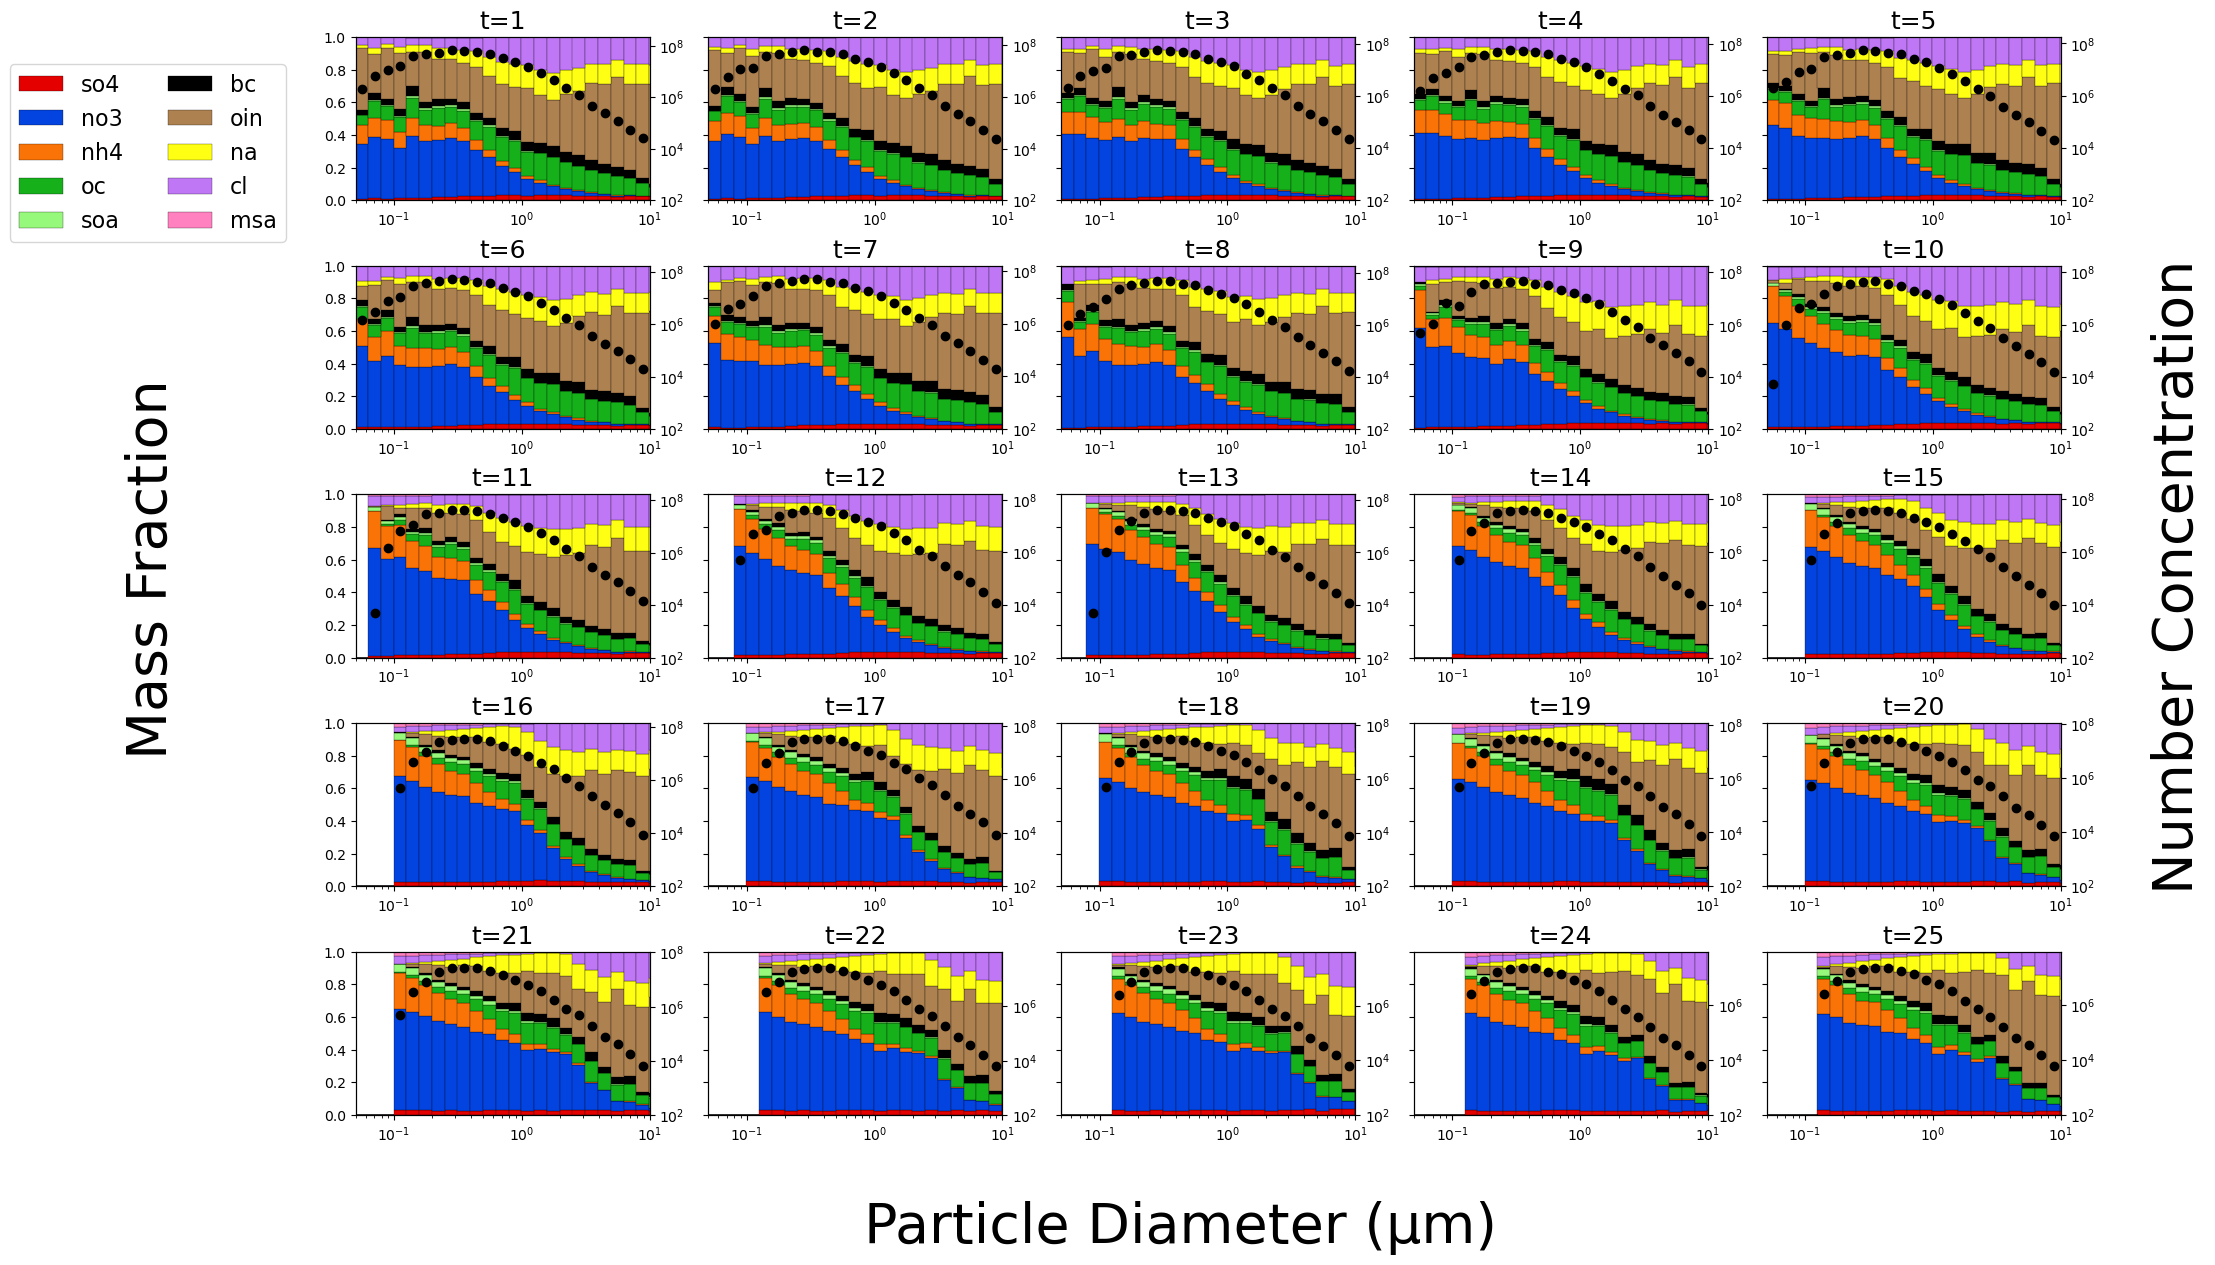

In [16]:
# Instead of the two nested loops, could just use one nested loop and define a list of all the colors
spec_labels_plt_order = ['so4','no3','nh4','oc','soa','bc','oin','na','cl','msa']

# colors = ['xkcd:purple', 'xkcd:green', 'xkcd:blue', 'xkcd:pink', 'xkcd:brown', 'xkcd:red', 'xkcd:light blue', 'xkcd:magenta', 'xkcd:light brown', 'xkcd:orange', 
#               'xkcd:light green', 'xkcd:very light purple']
colors = ['xkcd:red', 'xkcd:blue', 'xkcd:orange', 'xkcd:green', 'xkcd:light green', 'xkcd:black', 'xkcd:light brown', 'xkcd:yellow', 
              'xkcd:light purple', 'xkcd:pink']

fig, ax1 = plt.subplots(5, 5, sharey= True, figsize= (22, 14))
fig.subplots_adjust(wspace= 0.2, hspace= 0.4)
ax1 = ax1.ravel()
ax2 = np.array(ax1)

for t in range(len(t_index)):
    ax2[t] = ax1[t].twinx()
    for i in range(len(mass_frac_binned_plt[0])):
        ax1[t].bar(diam_bins_geomean, mass_frac_binned_plt[t][i], diam_bins_width, bottom= np.sum(mass_frac_binned_plt[t][0:i], axis=0), label= spec_labels_plt_order[i], color= colors[i], ec= 'black', lw= 0.2)
    
    ax1[t].set_xscale('log')
    ax1[t].set_xlim(5e-2, 1e1) # change, did not have this line beforehand
    ax1[t].set_yticks(np.linspace(0, 1, 6))
    ax1[t].set_title('t=' + str(t_index[t] + 1), fontsize= 18)
    ax2[t].plot(diam_bins_geomean, num_conc_binned[t][0], 'ko')
    ax2[t].set_yscale('log')
    ax2[t].set_ylim(1e2)
    
fig.supxlabel('Particle Diameter (µm)', fontsize= 40)
fig.supylabel('Mass Fraction', fontsize= 40)
ax2[14].set_ylabel('Number Concentration', labelpad= 40, fontsize=40)
ax1[24].legend(ncol=2, bbox_to_anchor= (-5, 6.5), fontsize= 16, fancybox= True)
# plt.savefig('/data/keeling/a/ttj2/python/plots/mfnc_t' + str(t_index[t] + 1) + '.png')

In [17]:
### Using linear diameter bins to match kerri's plots
# make edges of size bins
diam_bins_lin = np.linspace(1e-1, 9.5e-1, 18)

In [18]:
### Using linear diameter bins to match kerri's plots
# Bin particles
# Initialize lists for binned particles
fresh_binned = []
aged_binned = []
non_primary_binned = []

# Fill in lists, lists are 25x9x2x50:
# 25 timesteps, 9 species, a tuple of 2 arrays each of shape 50, the first being num conc in the size bins, the second being size bin edges
for t in range(len(t_index)):
    fb = []
    ab = []
    npb = []
    for i in range(len(primary_mass_frac_list)):
        fb.append(np.histogram(fresh_diam[t][i], diam_bins_lin, weights= fresh_num_conc[t][i]))
        ab.append(np.histogram(aged_diam[t][i], diam_bins_lin, weights= aged_num_conc[t][i]))
        npb.append(np.histogram(non_primary_diam[t][i], diam_bins_lin, weights= non_primary_num_conc[t][i]))
    fresh_binned.append(fb)
    aged_binned.append(ab)
    non_primary_binned.append(npb)

In [19]:
### Using linear diameter bins to match kerri's plots
# calculate geometric mean for locations of bars/bins in plots
diam_bins_mean = (fresh_binned[0][0][1][1:] + fresh_binned[0][0][1][:-1]) / 2

# calculate width of bars/bins for plots
diam_bins_width = fresh_binned[0][0][1][1:] - fresh_binned[0][0][1][:-1]

num_conc_binned = []

for t in range(len(t_index)):
    num_conc_binned.append(np.histogram(aero_particle_diam[t], diam_bins_lin, weights= aero_num_conc[t]))
    
# check to see if num_conc_binned can just be replaced by total_binned_num_conc
# I don't think it will be replaceable completely because num_conc_binned seems to account for number concentrations of all particles,
# whereas total_binned_num_conc may just account for the primary species ???

In [20]:
### Using linear diameter bins to match kerri's plots

# Exclude co3 and ca in mass frac arrays and plots, as they are found to have zero mass in this simulation
excluded_indices = [13, 15]

mass_binned = []
for t in range(len(t_index)):
    mb = []
    for i in range(int(len(species)-1)):
        if i not in soa_indices + excluded_indices:
            mb.append((np.histogram(aero_particle_diam[t], diam_bins_lin, weights= aero_particle_mass[t][i]))[0])
            
    # binned sum of SOA species masses
    soa_mb = np.histogram(aero_particle_diam[t], diam_bins_lin, weights= np.sum(aero_particle_mass[t][soa_indices[:]], axis=0))[0]
    mb.append(soa_mb)
    mass_binned.append(mb)
    
total_mass_binned = []
for t in range(len(t_index)):
    total_mass_binned.append(np.sum(mass_binned[t], axis=0))

mass_frac_binned = []
for t in range(len(t_index)):
    mass_frac_binned.append(np.nan_to_num(mass_binned[t] / total_mass_binned[t]))
    
indices_plt_order = [0, 1, 3, 7, 9, 8, 6, 5, 2, 4]
mass_frac_binned_plt = []
for t in range(len(t_index)):
    mfbp = np.zeros((10, 17))
    for i in range(len(indices_plt_order)):
        mfbp[i] = mass_frac_binned[t][indices_plt_order[i]]
    mass_frac_binned_plt.append(mfbp)

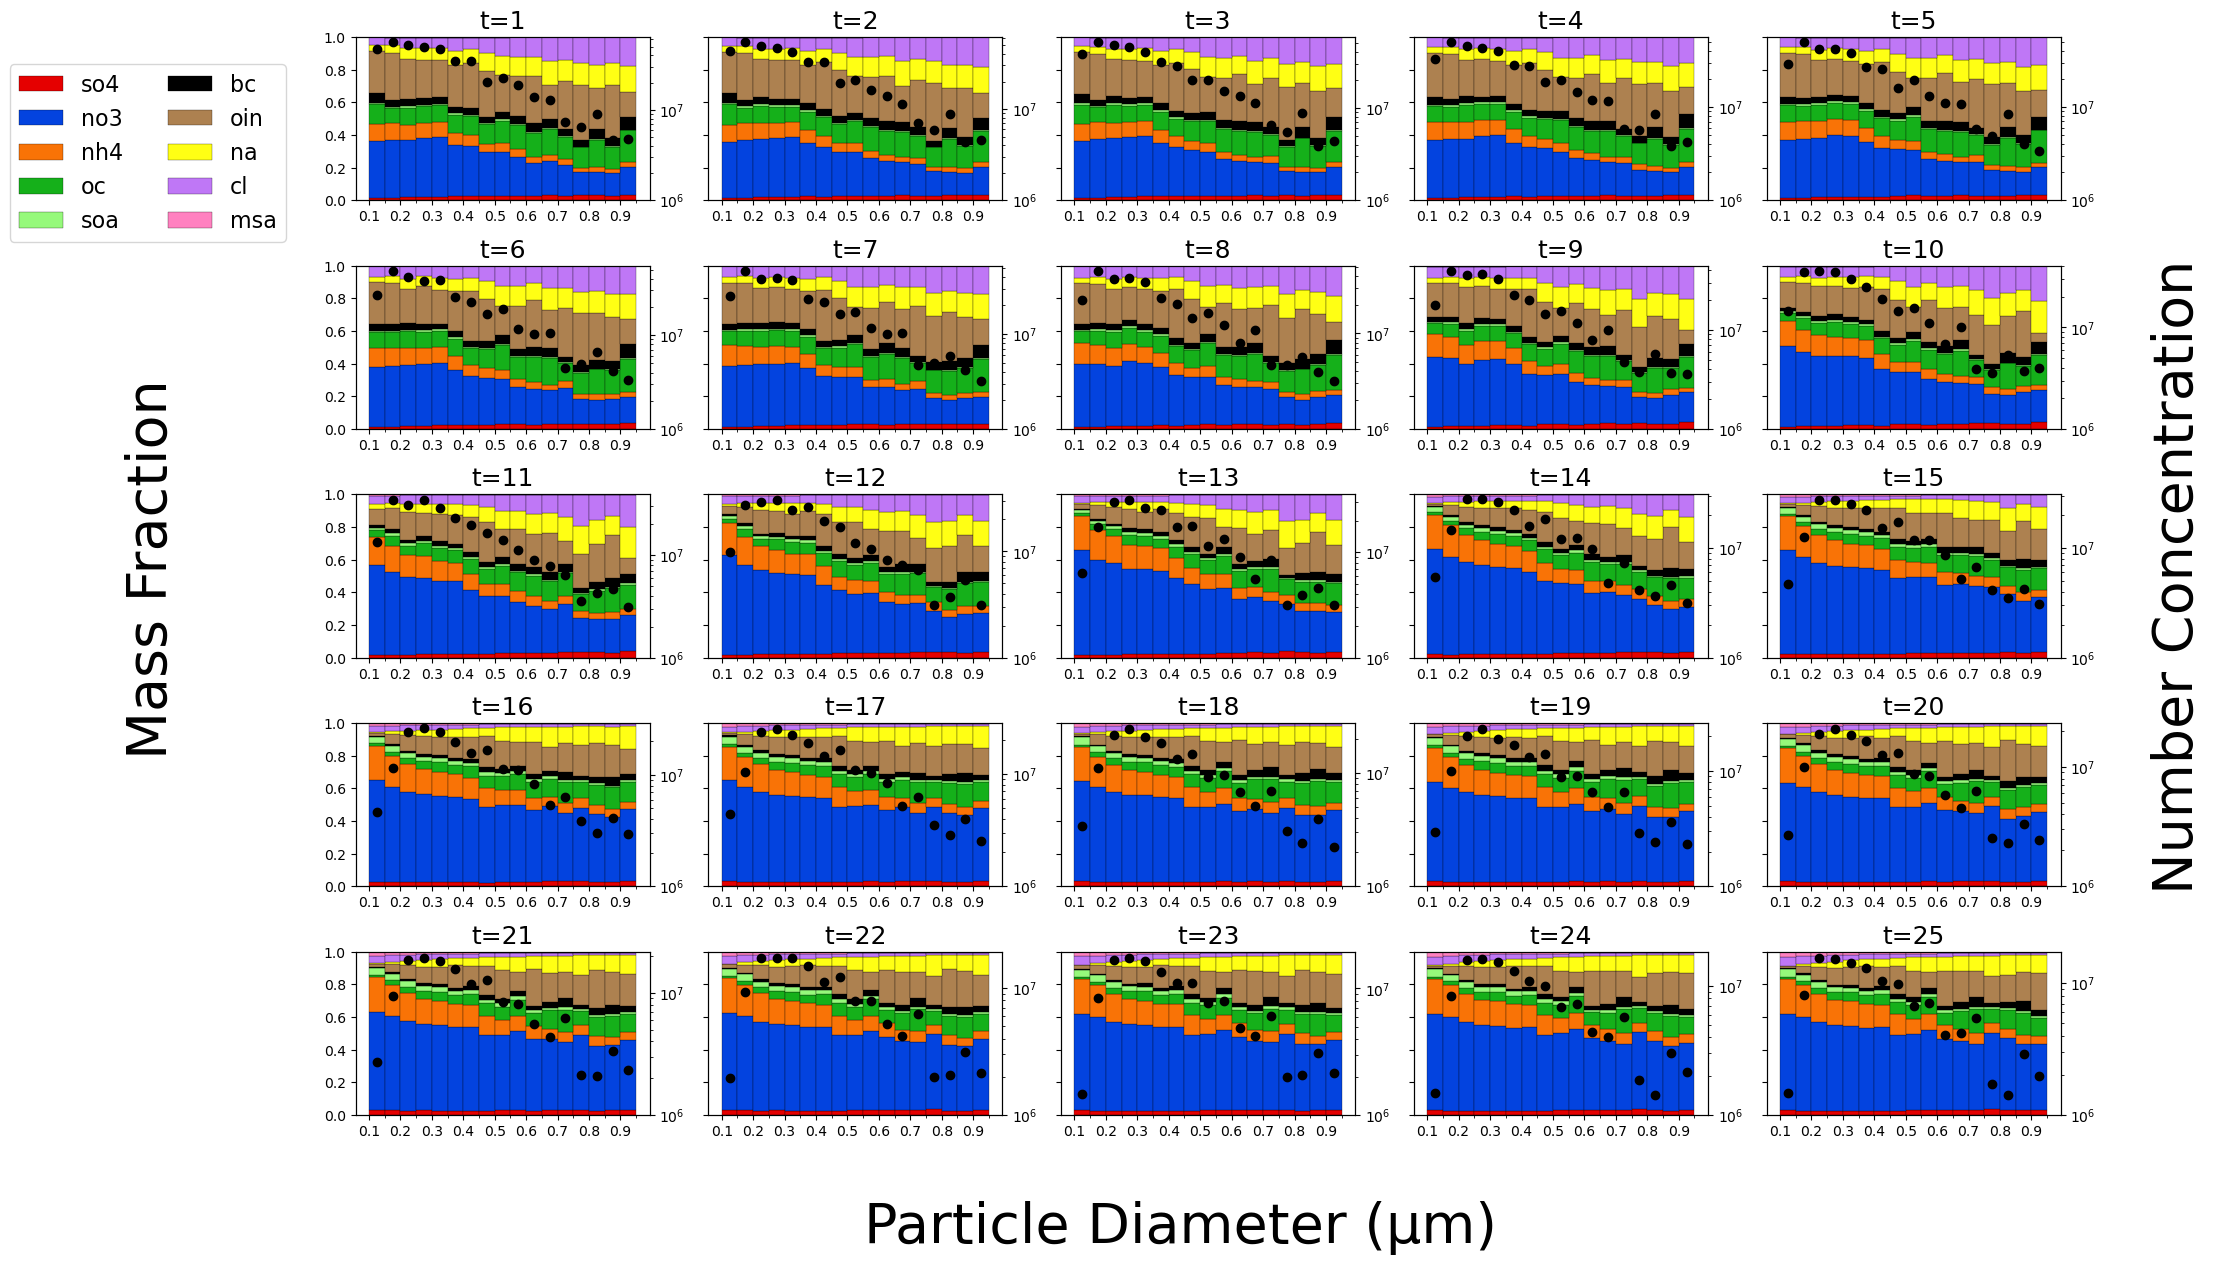

In [21]:
# Instead of the two nested loops, could just use one nested loop and define a list of all the colors
spec_labels_plt_order = ['so4','no3','nh4','oc','soa','bc','oin','na','cl','msa']

# colors = ['xkcd:purple', 'xkcd:green', 'xkcd:blue', 'xkcd:pink', 'xkcd:brown', 'xkcd:red', 'xkcd:light blue', 'xkcd:magenta', 'xkcd:light brown', 'xkcd:orange', 
#               'xkcd:light green', 'xkcd:very light purple']
colors = ['xkcd:red', 'xkcd:blue', 'xkcd:orange', 'xkcd:green', 'xkcd:light green', 'xkcd:black', 'xkcd:light brown', 'xkcd:yellow', 
              'xkcd:light purple', 'xkcd:pink']

fig, ax1 = plt.subplots(5, 5, sharey= True, figsize= (22, 14))
fig.subplots_adjust(wspace= 0.2, hspace= 0.4)
ax1 = ax1.ravel()
ax2 = np.array(ax1)

for t in range(len(t_index)):
    ax2[t] = ax1[t].twinx()
    for i in range(len(mass_frac_binned_plt[0])):
        ax1[t].bar(diam_bins_mean, mass_frac_binned_plt[t][i], diam_bins_width, bottom= np.sum(mass_frac_binned_plt[t][0:i], axis=0), label= spec_labels_plt_order[i], color= colors[i], ec= 'black', lw= 0.2)
    
    ax1[t].set_xticks(np.linspace(1e-1, 9e-1, 9))
    ax1[t].set_xticks(np.linspace(1.5e-1, 9.5e-1, 9), minor= True)
    ax1[t].set_yticks(np.linspace(0, 1, 6))
    ax1[t].margins(y=0)
    ax1[t].set_title('t=' + str(t_index[t] + 1), fontsize= 18)
    ax2[t].plot(diam_bins_mean, num_conc_binned[t][0], 'ko')
    ax2[t].set_yscale('log')
    ax2[t].set_ylim(1e6)
    
fig.supxlabel('Particle Diameter (µm)', fontsize= 40)
fig.supylabel('Mass Fraction', fontsize= 40)
ax2[14].set_ylabel('Number Concentration', labelpad= 40, fontsize=40)
ax1[24].legend(ncol=2, bbox_to_anchor= (-5, 6.5), fontsize= 16, fancybox= True)
# plt.savefig('/data/keeling/a/ttj2/python/plots/mfnc_t' + str(t_index[t] + 1) + '.png')

In [22]:
# Monday May 8 work, oin prim index = 5, oc = 6, bc = 7

# Identify 6 different classifications by which all particles can be distinguished out of OIN, OC, and BC:
# 1 - only contains OIN
# 2 - only contains OC(cooking)
# 3 - only contains OC and BC together(traffic)
# 4 - contains BOTH OIN and OC(cooking)
# 5 - contains ALL OF OIN, OC, and BC(traffic)
# 6 - contains NONE OF OIN, OC, or BC
oin = (primary_mass_frac_list[5][0] > 0) & (primary_mass_frac_list[6][0] == 0) & (primary_mass_frac_list[7][0] == 0)
oc = (primary_mass_frac_list[6][0] > 0) & (primary_mass_frac_list[5][0] == 0) & (primary_mass_frac_list[7][0] == 0)
oc_bc = (primary_mass_frac_list[6][0] > 0) & (primary_mass_frac_list[7][0] > 0) & (primary_mass_frac_list[5][0] == 0)
oin_oc = (primary_mass_frac_list[5][0] > 0) & (primary_mass_frac_list[6][0] > 0) & (primary_mass_frac_list[7][0] == 0)
oin_oc_bc = (primary_mass_frac_list[5][0] > 0) & (primary_mass_frac_list[6][0] > 0) & (primary_mass_frac_list[7][0] > 0)
none = (primary_mass_frac_list[5][0] == 0) & (primary_mass_frac_list[6][0] == 0) & (primary_mass_frac_list[7][0] == 0)


test_classes = [oin, oc, oc_bc, oin_oc, oin_oc_bc, none]
test_class_labels = ['oin', 'oc', 'oc_bc', 'oin_oc', 'oin_oc_bc', 'non_oin_oc_bc']

# create masks for each of the classifications
mask_list = []

for i in range(len(test_classes)):
    # fresh mask: secondary mass fraction < 0.2
    mask_list.append(test_classes[i] & (mass_frac_secondary[0] < 0.2))
    # aged mask: secondary mass fraction > 0.2
    mask_list.append(test_classes[i] & (mass_frac_secondary[0] > 0.2))

In [23]:
# Particle diameters and number concentrations masked by previously defined classifications

diam_list = []
num_conc_list = []

for i in range(len(mask_list)):
    diam_list.append(aero_particle_diam[0][mask_list[i]])
    num_conc_list.append(aero_num_conc[0][mask_list[i]])

In [24]:
# Bin particles, weighted by their number concentrations

binned_list = []

for i in range(len(mask_list)):
    binned_list.append((np.histogram(diam_list[i], diam_bins, weights= num_conc_list[i])[0]))

# Calculate total number concentration for each bin
total_binned_num_conc = np.sum(binned_list, axis= 0)

# Calculate relative number fractions for each bin
frac_list = []

for i in range(len(mask_list)):
    frac_list.append(np.nan_to_num(binned_list[i] / total_binned_num_conc))

/tmp/ipykernel_150821/3843664627.py:15: RuntimeWarning: invalid value encountered in divide
  frac_list.append(np.nan_to_num(binned_list[i] / total_binned_num_conc))


In [25]:
# calculate geometric mean for locations of bars in each bin in plots
diam_bins_geomean = np.sqrt(np.histogram(diam_list[0], diam_bins, weights= num_conc_list[0])[1][1:] * np.histogram(diam_list[0], diam_bins, weights= num_conc_list[0])[1][:-1])

# calculate width of bars/bins for plots
diam_bins_width = np.histogram(diam_list[0], diam_bins, weights= num_conc_list[0])[1][1:] - np.histogram(diam_list[0], diam_bins, weights= num_conc_list[0])[1][:-1]
# binned_list[0][1:] - binned_list[0][:-1]

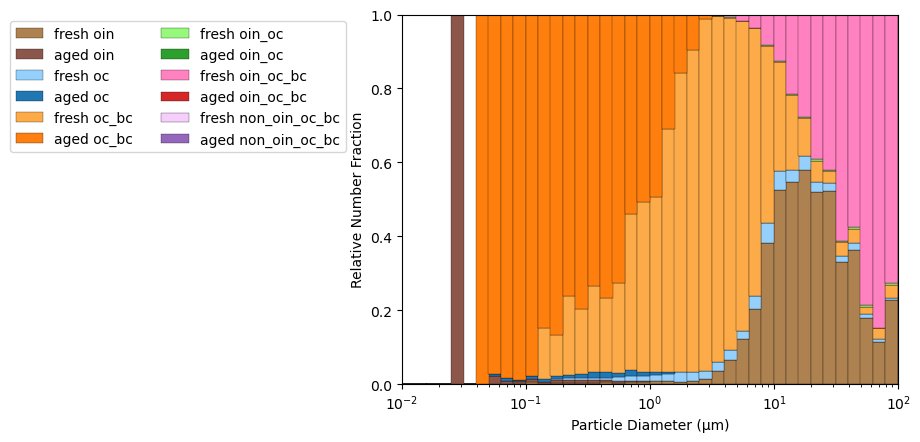

In [26]:
# Make each calssification a similar color for fresh and aged, like a solid for fresh and then a pastel for aged maybe

fa = ['fresh ', 'aged ']
aged_colors = ['tab:brown','tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
fresh_colors = ['xkcd:light brown', 'xkcd:light blue', 'xkcd:light orange', 'xkcd:light green', 'xkcd:pink', 'xkcd:very light purple']

# colors = ['xkcd:purple', 'xkcd:green', 'xkcd:blue', 'xkcd:pink', 'xkcd:brown', 'xkcd:red', 'xkcd:light blue', 'xkcd:teal', 'xkcd:tan', 'xkcd:orange', 
#               'xkcd:light green', 'xkcd:mustard']

fig, ax = plt.subplots()

for i in range(int(len(mask_list)/2)):
    ax.bar(diam_bins_geomean, frac_list[2*i], diam_bins_width, bottom= np.sum(frac_list[0:(2*i)], axis=0), label= fa[0] + test_class_labels[i], color= fresh_colors[i], ec= 'black', lw= 0.2)
    ax.bar(diam_bins_geomean, frac_list[(2*i) + 1], diam_bins_width, bottom= np.sum(frac_list[0:((2*i) + 1)], axis=0), label= fa[1] + test_class_labels[i], color= aged_colors[i],  ec= 'black', lw= 0.2)

ax.set_xscale('log')
ax.set_xlim(1e-2, 1e2)
ax.set_xlabel('Particle Diameter (µm)')
ax.set_ylabel('Relative Number Fraction')
ax.legend(ncol=2, bbox_to_anchor= (-0.1, 1), fancybox= True)